In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, average_precision_score
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import xgboost as xgb

In [1]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
def load_split_data(train_path, validation_path, test_path):
    train_data = pd.read_csv(train_path)
    validation_data = pd.read_csv(validation_path)
    test_data = pd.read_csv(test_path)
    X_train = train_data['processed_text']
    y_train = train_data['spam']
    X_val = validation_data['processed_text']
    y_val = validation_data['spam']
    X_test = test_data['processed_text']
    y_test = test_data['spam']
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = load_split_data('d:/cmi/sem 4/AppliedML/ass2/data/train.csv', 'd:/cmi/sem 4/AppliedML/ass2/data/validation.csv', 'd:/cmi/sem 4/AppliedML/ass2/data/test.csv')

In [5]:
def train_and_log_model(model_name, X_train, y_train, X_val, y_val, params={},tags={}):
    with mlflow.start_run(run_name=model_name):
        
        if model_name == 'logistic_regression':
            model = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(random_state=42, **params))
            ])
        elif model_name == 'naive_bayes':
            model = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB(**params))
            ])
        elif model_name == 'lightgbm':
            model = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', lgb.LGBMClassifier(random_state=42, force_row_wise=True, **params))
            ])
        else:
            raise ValueError("Model name not recognized.")

        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred_val)
        aucpr = average_precision_score(y_val, model.predict_proba(X_val)[:, 1])

        
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("aucpr", aucpr)
        mlflow.sklearn.log_model(model, f"model_{model_name}")
        # After training and logging metrics, register the model
        mlflow.sklearn.log_model(model, f"model_{model_name}")

        
        run_id = mlflow.active_run().info.run_id
        client = MlflowClient()
        try:
            client.create_registered_model(model_name)
        except Exception as e:
            print(f"Model {model_name} already exists in the registry.")

        # Create a new version of the model in the registry
        model_uri = f"runs:/{run_id}/model_{model_name}"
        model_version_info = client.create_model_version(model_name, model_uri, run_id)

        
        tags['Created by'] = 'subhashree' 
        for tag_key, tag_value in tags.items():
            client.set_model_version_tag(
                model_name,
                model_version_info.version,
                tag_key,
                tag_value
            )

        print(f"Model {model_name}, version {model_version_info.version} registered in the MLflow Model Registry with tags {tags}.")
        print(f"Model: {model_name}, Accuracy: {accuracy}, AUCPR: {aucpr}")

In [6]:

mlflow.set_experiment("Email Spam Classification")

2024/02/20 18:28:58 INFO mlflow.tracking.fluent: Experiment with name 'Email Spam Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/cmi/sem%204/AppliedML/ass2/src/mlruns/466491286155145982', creation_time=1708433938873, experiment_id='466491286155145982', last_update_time=1708433938873, lifecycle_stage='active', name='Email Spam Classification', tags={}>

In [7]:
tags = {
    "Review": "Passed",
    "Ready for Deployment": "Yes"
}

In [8]:

model_names = ['logistic_regression', 'naive_bayes', 'lightgbm']
for model_name in model_names:
    train_and_log_model(model_name, X_train, y_train, X_val, y_val, tags=tags)

c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model logistic_regression, version 1 registered in the MLflow Model Registry with tags {'Review': 'Passed', 'Ready for Deployment': 'Yes', 'Created by': 'subhashree'}.
Model: logistic_regression, Accuracy: 0.9738219895287958, AUCPR: 0.9957665730059126


c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model naive_bayes, version 1 registered in the MLflow Model Registry with tags {'Review': 'Passed', 'Ready for Deployment': 'Yes', 'Created by': 'subhashree'}.
Model: naive_bayes, Accuracy: 0.8996509598603839, AUCPR: 0.9910803188993038
[LightGBM] [Info] Number of positive: 830, number of negative: 2606
[LightGBM] [Info] Total Bins 67907
[LightGBM] [Info] Number of data points in the train set: 3436, number of used features: 2545
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241560 -> initscore=-1.144146
[LightGBM] [Info] Start training from score -1.144146


c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model lightgbm, version 1 registered in the MLflow Model Registry with tags {'Review': 'Passed', 'Ready for Deployment': 'Yes', 'Created by': 'subhashree'}.
Model: lightgbm, Accuracy: 0.9808027923211169, AUCPR: 0.9941261258749756


In [9]:
# Train and log models
model_names = ['logistic_regression', 'naive_bayes', 'lightgbm']
for model_name in model_names:
    train_and_log_model(model_name, X_train, y_train, X_val, y_val)

c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model logistic_regression already exists in the registry.
Model logistic_regression, version 2 registered in the MLflow Model Registry with tags {'Created by': 'subhashree'}.
Model: logistic_regression, Accuracy: 0.9738219895287958, AUCPR: 0.9957665730059126


c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model naive_bayes already exists in the registry.
Model naive_bayes, version 2 registered in the MLflow Model Registry with tags {'Created by': 'subhashree'}.
Model: naive_bayes, Accuracy: 0.8996509598603839, AUCPR: 0.9910803188993038
[LightGBM] [Info] Number of positive: 830, number of negative: 2606
[LightGBM] [Info] Total Bins 67907
[LightGBM] [Info] Number of data points in the train set: 3436, number of used features: 2545
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241560 -> initscore=-1.144146
[LightGBM] [Info] Start training from score -1.144146


c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Python3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model lightgbm already exists in the registry.
Model lightgbm, version 2 registered in the MLflow Model Registry with tags {'Created by': 'subhashree'}.
Model: lightgbm, Accuracy: 0.9808027923211169, AUCPR: 0.9941261258749756


In [10]:
! mlflow ui

^C


From the above plots of accuracy and aupcr in the UI,  we test it on lightgbm model

In [11]:
model_uri = "models:/lightgbm/2"
model = mlflow.sklearn.load_model(model_uri)

In [12]:

y_pred = model.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
aucpr = average_precision_score(y_test, model.predict_proba(X_test)[:, 1])

In [14]:

# Print out the metrics
print(f"Accuracy on test dataset: {accuracy}")
print(f"AUCPR on test dataset: {aucpr}")

Accuracy on test dataset: 0.9842931937172775
AUCPR on test dataset: 0.9936950645413544


Text(113.9222222222222, 0.5, 'Actual label')

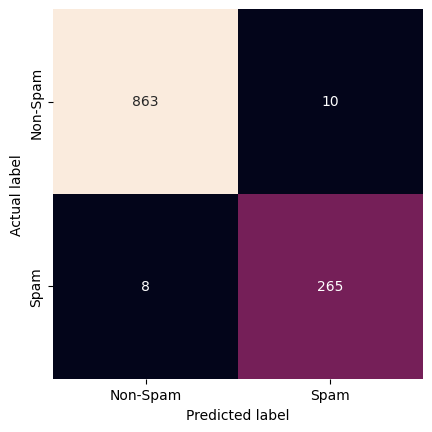

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
labels = ['Non-Spam', 'Spam']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [22]:

pred_prob = list((y_pred))

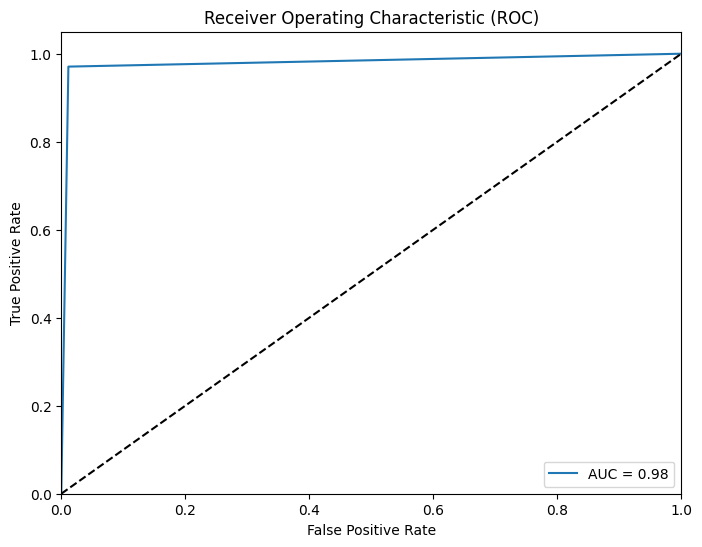

In [23]:

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = roc_auc_score(y_test, pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()